This model was used to regress on inter and intra-session not-pre-processed images. 
The model is reduced Ameri-like architecture, where also kernel size and pool size are modified.<br>
Image size is 56 x 1500, where 1500 represents 150 ms windows, with overlap of 40 ms.<br>
For example, for intra-session data structure was as follows:
Number of training images - 5046. This represents sessions: 1, 2, and 3.<br>
Number of validation images - 1818. Represent session 4. <br>
Number of training images - 1818. Represent session 5.<br>

________________________________________________________________________________
GS parameters intra-session:

params = {'nbr_filters_hid1': [32,64],<br>
          'nbr_filters_hid2': [16,24,32],<br>
          'drop_rate': list(np.linspace(0,0.5,6).astype('float32')),<br>
           'lambda_': list(np.linspace(1e-5,1e-1,5).astype('float32')) + [0]
                }

________________________________________________________________________________

GS parameters inter-session:

params = {'nbr_filters_hid1': [32,64, 128, 256],<br>
          'nbr_filters_hid2': [16,24,32, 64],<br>
          'drop_rate': list(np.linspace(0,0.5,6).astype('float32')),<br>
           'lambda_': list(np.linspace(1e-5,1e-1,5).astype('float32')) + [0]
                }

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


First install specific version of tensorflow

In [ ]:
!pip uninstall tensorflow 

In [ ]:
!pip install tensorflow==2.1 

In [ ]:
!pip install git+https://github.com/autonomio/talos@1.0

Create model and helper functions

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import ReLU
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from talos.utils.gpu_utils import parallel_gpu_jobs

import tensorflow as tf
import talos as ta
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# function for plotting the results
def plot_the_labels(test_generator, pred_model,path_filename = "../Results/test185.png"):
  """Input: test generator, predicted labels and path/filename where resulting image will be saved.
  Define path_filename=False if you dont want to save"""
  fs=10000/1100
  labels1=[]
  prediction1=[]
  labels2=[]
  prediction2=[]
  labels3=[]
  prediction3=[]
  labels4=[]
  prediction4=[]
  labels5=[]
  prediction5=[]
  fig,axs=plt.subplots(5,1,figsize=(30,15))
  axs[0].tick_params(axis='x',labelsize=20)
  axs[0].tick_params(axis='y',labelsize=20)
  axs[1].tick_params(axis='x',labelsize=20)
  axs[1].tick_params(axis='y',labelsize=20)
  axs[2].tick_params(axis='x',labelsize=20)
  axs[2].tick_params(axis='y',labelsize=20)
  axs[3].tick_params(axis='x',labelsize=20)
  axs[3].tick_params(axis='y',labelsize=20)
  axs[4].tick_params(axis='x',labelsize=20)
  axs[4].tick_params(axis='y',labelsize=20)

  for gen_ind in np.arange(1,len(test_generator)+1,1):
    n=(gen_ind-1)*bs
    print(gen_ind)
    for i in range (0,np.shape(test_generator[gen_ind-1][1])[0]):
      prediction1.append(pred_model[n+i,0])
      labels1.append(test_generator[gen_ind-1][1][i,0])

      prediction2.append(pred_model[n+i,1])
      labels2.append(test_generator[gen_ind-1][1][i,1])

      prediction3.append(pred_model[n+i,2])
      labels3.append(test_generator[gen_ind-1][1][i,2])

      prediction4.append(pred_model[n+i,3])
      labels4.append(test_generator[gen_ind-1][1][i,3])

      prediction5.append(pred_model[n+i,4])
      labels5.append(test_generator[gen_ind-1][1][i,4])

  x=np.arange(0,len(labels1),1)/fs
  a=int(len(labels1)/8)
  xt=x[np.arange(0,8,1)*a]

  
  plt.setp(axs, yticks=[0, 5, 10])#xticklabels=['a', 'b', 'c'],
  axs[0].plot(np.arange(0,len(labels1),1)/fs,labels1,color='#DE3163',label='ground truth',linewidth=3)
  axs[0].plot(np.arange(0,len(labels1),1)/fs,prediction1, color='#787276',label='prediction',linewidth=5)
  axs[0].legend(loc="upper right", prop={'size': 27})
  axs[0].set_ylabel('thumb',fontsize=20)

  axs[1].plot(np.arange(0,len(labels2),1)/fs,labels2,color='#DE3163',label='ground truth',linewidth=3)
  axs[1].plot(np.arange(0,len(labels2),1)/fs,prediction2, color='#787276',label='prediction',linewidth=5)
  #axs[1].legend(loc="upper right")
  axs[1].set_ylabel('index finger',fontsize=20)

  axs[2].plot(np.arange(0,len(labels3),1)/fs,labels3,color='#DE3163',label='ground truth',linewidth=3)
  axs[2].plot(np.arange(0,len(labels3),1)/fs,prediction3, color='#787276',label='prediction',linewidth=5)
  #axs[2].legend(loc="upper right")
  axs[2].set_ylabel('middle finger',fontsize=20)

  axs[3].plot(np.arange(0,len(labels4),1)/fs,labels4,color='#DE3163',label='ground truth',linewidth=3)
  axs[3].plot(np.arange(0,len(labels4),1)/fs,prediction4, color='#787276',label='prediction',linewidth=5)
  #axs[3].legend(loc="upper right")
  axs[3].set_ylabel('ring finger',fontsize=20)

  axs[4].plot(np.arange(0,len(labels5),1)/fs,labels5,color='#DE3163',label='ground truth',linewidth=3)
  axs[4].plot(np.arange(0,len(labels5),1)/fs,prediction5, color='#787276',label='prediction',linewidth=5)
  #axs[4].legend(loc="upper right")
  axs[4].set_ylabel('little finger',fontsize=20)
  axs[4].set_xlabel('time[s]',fontsize=25)
  if path_filename:
    fig.savefig(path_filename)

#step dacay
def step_decay(epoch):
  # initial learning rate
  initial_l_r = 0.001
  # half the the learning rate each 5 epochs
  drop = 0.5
  epochs_drop = 5
  lrate = initial_l_r * np.power(drop,np.floor((1 + epoch)/epochs_drop))

  return lrate

# model
def create_CNN_Ameri_like_model(dim1,dim2,dim_labels = 5,  lambda_ = 1.675e-5, drop_rate = 0.1, nbr_hid1 = 80, nbr_hid2 = 24, kernel_initializer='glorot_uniform'):

    input_dim = (dim1,dim2,1)
    visible = Input(shape = input_dim)

    ######################################## CONVOLUTIONAL LAYERS ##########################################
    # First block
    conv1 = Conv2D(16, kernel_size = (3,5), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(visible)
    norm1 = BatchNormalization()(conv1)
    act1 = ReLU()(norm1)
    pool1 = AveragePooling2D(pool_size = (1,2))(act1)

    # Second Block
    conv2 = Conv2D(32, kernel_size = (3,5), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool1)
    norm2 = BatchNormalization()(conv2)
    act2 = ReLU()(norm2)
    pool2 = AveragePooling2D(pool_size = (1,2))(act2)

    # Third Block
    conv4 = Conv2D(64, kernel_size = (3,5), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool2)
    norm4 = BatchNormalization()(conv4)
    act4 = ReLU()(norm4)
    pool4 = AveragePooling2D(pool_size = (1,2))(act4)

    # Fourth Block
    conv5 = Conv2D(64, kernel_size = (3,5), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool4)
    norm5 = BatchNormalization()(conv5)
    act5 = ReLU()(norm5)
    pool5 = AveragePooling2D(pool_size = (1,2))(act5)

    # Fifth Block
    conv6 = Conv2D(64, kernel_size = (3,5), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool5)
    norm6 = BatchNormalization()(conv6)
    act6 = ReLU()(norm6)
    pool6 = AveragePooling2D(pool_size = (1,2))(act6)

    # Sixth Block
    conv5 = Conv2D(64, kernel_size = (3,5), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool6)
    norm5 = BatchNormalization()(conv5)
    act5 = ReLU()(norm5)
    pool5 = AveragePooling2D(pool_size = (1,2))(act5)

    # Seventh Block
    conv6 = Conv2D(32, kernel_size = (3,5), padding = 'same', kernel_regularizer= l2(lambda_), kernel_initializer=kernel_initializer)(pool5)
    norm6 = BatchNormalization()(conv6)
    act6 = ReLU()(norm6)

    ######################################## FULLY CONNECTED LAYERS #########################################

    # Fully connected layers 
    flat = Flatten()(act6)
    hid1 = Dense(nbr_hid1, activation = 'relu', kernel_regularizer = l2(lambda_))(flat)
    drop1 = Dropout(rate = drop_rate)(hid1)

    hid2 = Dense(nbr_hid2, activation = 'relu', kernel_regularizer = l2(lambda_))(drop1)
    drop2 = Dropout(rate = drop_rate)(hid2)

    ################################################ OUTPUT ################################################

    output = Dense(dim_labels, activation = 'linear', kernel_regularizer = l2(lambda_))(drop2) # linear activation for regression

    model = Model(inputs = visible, outputs = output)

    # Compile model 
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), loss = 'mean_squared_error') # mse loss for regerssion

    return model

def CreateFit_eng_ameri(train_generator,uselesss,valid_generator,useless,params):
    
    input_dim_r = params['nmb_rows']
    input_dim_c = params['nmb_columns']
    
    lambda_ = params['lambda_']
    drop_rate = params['drop_rate']
    nbr_hid1 = params['nbr_filters_hid1']
    nbr_hid2 = params['nbr_filters_hid2']
    kernel_initializer = params['kernel_initializer']
    
    model = create_CNN_Ameri_like_model(input_dim_r,input_dim_c,dim_labels = 5,  lambda_ = 1.675e-5, drop_rate = 0.1, nbr_hid1 = nbr_hid1, nbr_hid2 = nbr_hid2, kernel_initializer='glorot_uniform')
   
    # Defining the callbacks we want to use
    lrate_schedule = LearningRateScheduler(step_decay)
    early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
    callbacks_list = [lrate_schedule,early_stopper]
    
    out = model.fit(train_generator, epochs = 50, verbose = 1, callbacks = callbacks_list, validation_data = valid_generator)

    ########################## 
    """
    model.evaluate(test_generator,verbose=1)
    prediction=model.predict(test_generator,verbose=1)
    pp='/content/drive/Shared drives/Nikolina/Results/Report figures/rawsession'+str(session)+'.png'
    plot_the_labels(test_generator, prediction,path_filename =pp)"""
    ###########################

    return out, model

Now load the data and create dataframes containing images and corresponding target values.

In [ ]:
session=5
"""Fil the paths and batch size in the following lines """
df_filename=['','',''] # csv files where targets and coresponding images names are saved
#path to train csv file folder and file name
df_filename[0]='/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session'+str(session)+'/train_150ms.csv'
#path to validation csv file folder and file name
df_filename[1]='/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session'+str(session)+'/validation_150ms.csv'
#path to test csv file folder and file name
df_filename[2]='/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session'+str(session)+'/test_150ms.csv'
print(df_filename)

dir_=['','',''] #images folders
dir_[0]='/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session'+str(session)+'/Train'
dir_[1]='/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session'+str(session)+'/Validation'
dir_[2]='/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session'+str(session)+'/Test'
print(dir_)

#path to the folder where you want to store results
file_name='Results'

#fill the batch size
bs=16 #64
    
########## LOAD THE IMAGES AND TARGETS, AND CREATE GENERATORS ##########

nmb_rows=56 #define dimensions 
nmb_columns=1500 #define dimensions

#Create dataframes and datagenerators: 
#TRAIN
dft=pd.read_csv(df_filename[0]) #csv file
datagen=ImageDataGenerator(rescale=1/255) #rescale
train_generator=datagen.flow_from_dataframe(dataframe=dft, 
                                            directory= dir_[0], #images folder
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5"], # targets names in data frame
                                            class_mode="raw", # important for regression
                                            target_size=(nmb_rows,nmb_columns), # tuple of integers `(height, width)
                                            batch_size=bs, 
                                            color_mode="grayscale",
                                            shuffle=True) 

#VALIDATION
dfv=pd.read_csv(df_filename[1])
datagen=ImageDataGenerator(rescale=1/255)
valid_generator=datagen.flow_from_dataframe(dataframe=dfv, 
                                            directory=dir_[1], 
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5"], 
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), 
                                            batch_size=bs,
                                            color_mode="grayscale",
                                            shuffle=True)  

#TEST
#just read with shuffle=false to make sure final plots looks like expected
dfte=pd.read_csv(df_filename[2])
datagen=ImageDataGenerator(rescale=1/255)
test_generator=datagen.flow_from_dataframe(dataframe=dfte, 
                                            directory= dir_[2], 
                                            x_col="filename", y_col=["target1","target2","target3","target4","target5"], 
                                            class_mode="raw", 
                                            target_size=(nmb_rows,nmb_columns), 
                                            batch_size=bs,
                                            color_mode="grayscale",
                                            shuffle=False)

['/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session4/train_150ms.csv', '/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session4/validation_150ms.csv', '/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session4/test_150ms.csv']
['/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session4/Train', '/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session4/Validation', '/content/drive/Shared drives/Nikolina/Raw images/Images intra session/Session4/Test']
Found 1091 validated image filenames.
Found 364 validated image filenames.
Found 364 validated image filenames.


In [ ]:
#Grid search
params = {'nbr_filters_hid1': [32,64,128,256],
                'nbr_filters_hid2': [16,24,32,64],
                'drop_rate': list(np.linspace(0,0.5,6).astype('float32')),
                'lambda_': list(np.linspace(1e-5,1e-1,5).astype('float32')) + [0] ,
                'kernel_initializer':['glorot_uniform'],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns]  
                }

parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
scan_results = ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = file_name,
                       x_val=valid_generator, y_val = 0)

In [ ]:
path='/content/drive/Shared drives/Nikolina/Results/CNN - intra-ssesion - regression/results_session'+str(session)+'.csv'
results=pd.read_csv(path) 

In [ ]:
val_loss=results.val_loss
print(min(val_loss))
best=np.where(val_loss==min(val_loss))[0]
print(best)
print(val_loss[best])

5.257961869
[40]
40    5.257962
Name: val_loss, dtype: float64


In [ ]:
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [24],
                'drop_rate': [0.2],
                'lambda_': [1e-4] ,
                'kernel_initializer':['glorot_uniform'],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns]  
                }
                
for i in range(20):

  parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
  scan_results= ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'drive/My Drive/CNN raw results/session'+str(session)+'Valid',
                        x_val=valid_generator, y_val = 0)

In [ ]:
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [24],
                'drop_rate': [0.2],
                'lambda_': [1e-4] ,
                'kernel_initializer':['glorot_uniform'],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns]  
                }
                
for i in range(20):

  parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
  scan_results= ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'drive/My Drive/CNN raw results/session'+str(session)+'Test',
                        x_val=test_generator, y_val = 0)

  0%|          | 0/1 [00:00<?, ?it/s]

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 69 steps, validate for 23 steps
Epoch 1/50
69/69 [==============================] - 740s 11s/step - loss: 6.4064 - val_loss: 6.4971
Epoch 2/50
69/69 [==============================] - 18s 259ms/step - loss: 5.5398 - val_loss: 6.1815
Epoch 3/50
69/69 [==============================] - 18s 259ms/step - loss: 4.6327 - val_loss: 6.3368
Epoch 4/50
69/69 [==============================] - 18s 259ms/step - loss: 3.7821 - val_loss: 5.8668
Epoch 5/50
69/69 [==============================] - 18s 258ms/step - loss: 2.6396 - val_loss: 5.9216
Epoch 6/50
69/69 [==============================] - 18s 258ms/step - loss: 2.2873 - val_loss: 5.7831
Epoch 7/50
69/69 [==============================] - 18s 258ms/step - loss: 1.9266 - val_loss: 5.2423
Epoch 8/50
69/69 [==============================] - 18s 257ms/step - loss: 1.6750 - val_loss: 5.3341
Epoch 9/50
69/69 [==============================] - 18s 258ms/step - loss: 1.4176 - val_loss: 5.3255


100%|██████████| 1/1 [20:19<00:00, 1219.78s/it]


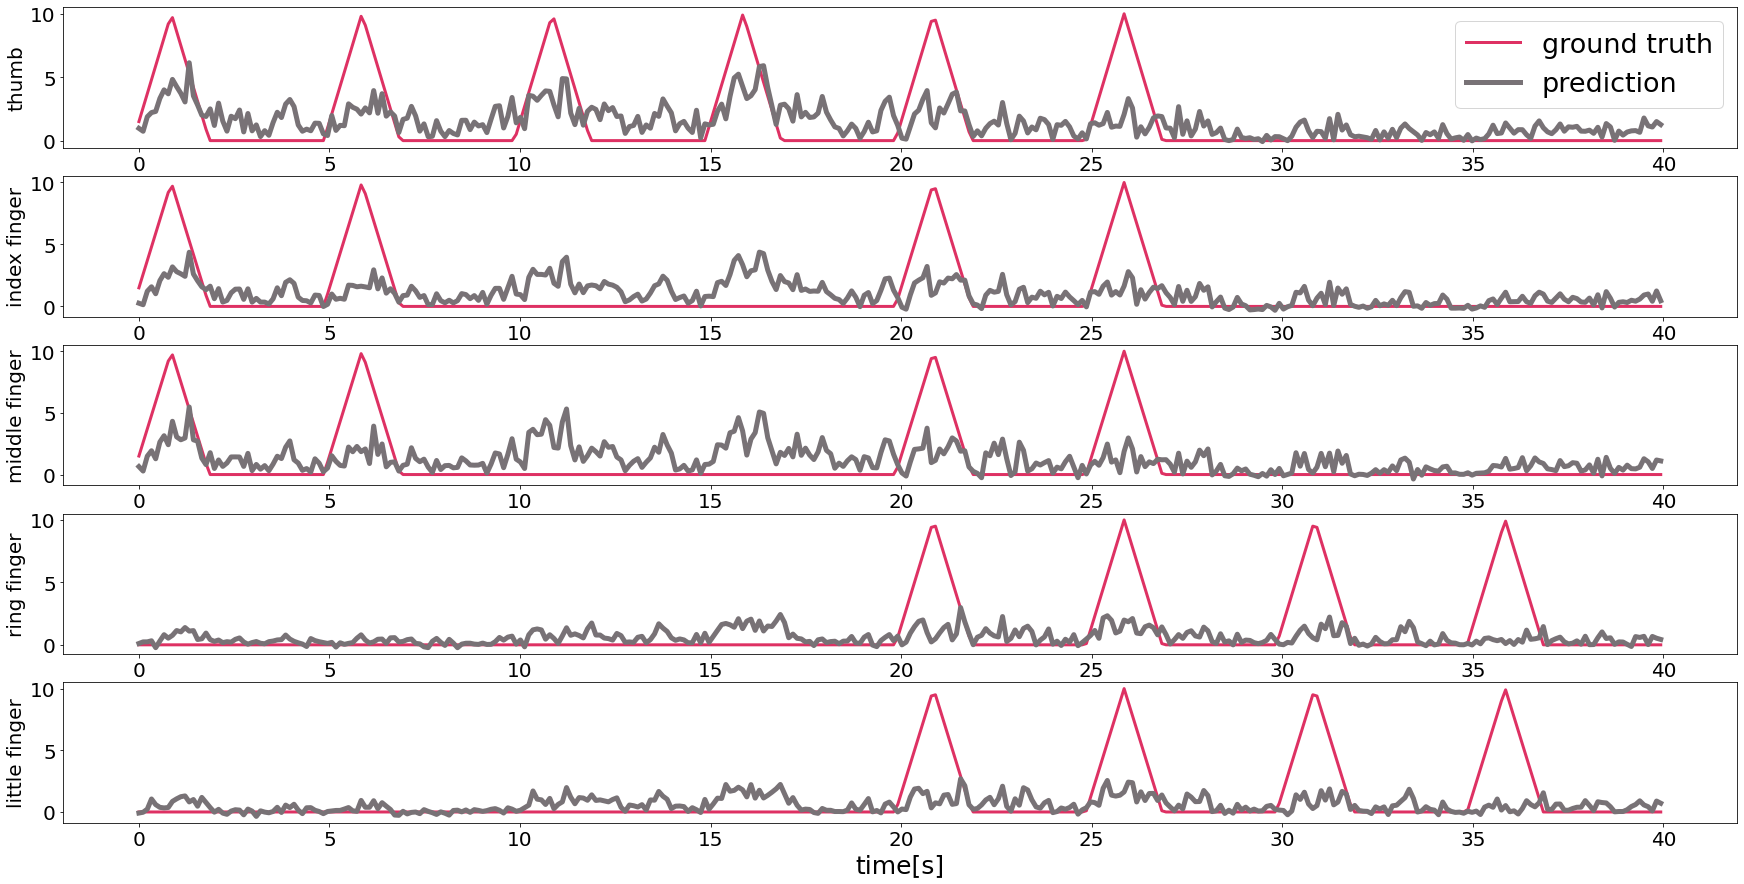

In [ ]:
params = {'nbr_filters_hid1': [64],
                'nbr_filters_hid2': [24],
                'drop_rate': [0.2],
                'lambda_': [1e-4] ,
                'kernel_initializer':['glorot_uniform'],
                'nmb_rows': [nmb_rows],
                'nmb_columns':[nmb_columns]  
                }
                
for i in range(1):

  parallel_gpu_jobs(allow_growth = True, fraction = 0.95)
  scan_results= ta.Scan(train_generator, None, params,  CreateFit_eng_ameri, experiment_name = 'plot',
                        x_val=test_generator, y_val = 0)

In [ ]:
predictions=[]
test_acc=[]
valid_acc=[]
train_acc=[]

#Run best model
input_dim_r = 56
input_dim_c = 1500

l=1e-1
dr=0.5
h1=32
h2=32

#model = eng_model(input_dim_r,input_dim_c, first_layer_filters,second_layer_filters,third_layer_filters,fully_connected,_lambda,drop_rate)


for i in range(1):
  print('\nTraining, iteration '+ str(i))
  model = create_CNN_Ameri_like_model(input_dim_r,input_dim_c,dim_labels = 5,  lambda_ = l, drop_rate = dr, nbr_hid1 = h1, nbr_hid2 = h2, kernel_initializer='glorot_uniform')

  lrate_schedule = LearningRateScheduler(step_decay)
  early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=13, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
  callbacks_list = [lrate_schedule,early_stopper]
  h= model.fit(train_generator, epochs = 50, verbose = 1, callbacks = callbacks_list, validation_data = valid_generator)
  prediction = model.predict(test_generator, verbose = 0)
  test_scores = model.evaluate(test_generator, verbose = 0)
  
  print('Train loss:' , h.history['loss'][-1])
  print('Test loss:',test_scores)
  print('Validation loss:',h.history['val_loss'][-1])

  predictions.append(prediction)

  test_acc.append(test_scores)
  train_acc.append(h.history['loss'][-1])
  valid_acc.append(h.history['val_loss'][-1])

In [ ]:
pp='/content/drive/Shared drives/Nikolina/Results/Report figures/rawsession1.png'
plot_the_labels(test_generator, prediction,path_filename =pp)

In [ ]:
print('train accuracy: '+ str(np.mean(train_acc)) + '+-' + str(np.std(train_acc)))
print('validation accuracy: '+ str(np.mean(valid_acc)) + '+-' + str(np.std(valid_acc)))
print('test accuracy: '+ str(np.mean(test_acc)) + '+-' + str(np.std(test_acc)))